# Part 2: Gradient Boosting with Stochasticity
This notebook follows from the basic implementaion of Gradient Boosting found in the previous notebook.  What follows is a basic implementation of the gradient boosting algorithm using stochasticity.  This implementation is a fequently used variation of the Gradient Boosting algorithm.  Stochastic Gradient Boosting was proposed by Friedman<sup>[1]</sup> and takes a cue from Brieman's bagging<sup>[2]</sup> in that we are simply fitting trees to a sampled subspace in order to bias our estimator with the hopes of reducing the variance.  Stochastic Gradient Boosting, as Friedman implemented it, utilized random sampling <b>without</b> replacement, where-as boostrapping samples are sampled <b>with</b> replacement.  The algorithm is identical to standard Gradient Boosting except we are now fitting our trees on subspaces instead of the full dataset.

## Importing and Data Handling
First, we will import any neccessary packages and prepare our data for modelling.  Then we will split our dataset into Test and Training sets which will be used throughout all of the notebooks covering GBTs. The dataset used also comes from Scikit-Learn, for documentation see <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston">here</a>

In [11]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.utils import shuffle,resample

In [17]:
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * .9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]
xi = X_train
yi = y_train

## Initialize Model Parameters
The cell below initializes the parameters that will be used in the algorithm, comments have been added in the code for further details. Additionally, we initialize some datasets which we will be using to compare our algorithm with Scikit-Learn's.

In [18]:
ei = 0 # initialization of error
predf = 0 # initial prediction 0
count = 1 # initial count we will reference 
test_predictions = 0 # initial test set prediction 0
mse_list_adap = [] #Creating the mse data set
lr = .01 #Setting the Learning rate
test_predictions_list = pd.DataFrame([])

## The Sampling Function
In the cell below we define a function to combine our target variable with the predictors in order to draw a sample without replacement. The function will be called at the beginning of each iteration.  We will be sampling 90% of our dataset each time.

In [19]:
def sampled(y,x):
    to_sample = np.column_stack([y,x])
    to_sample = pd.DataFrame(to_sample)
    sampled = to_sample.sample(frac=.9, replace=False)
    y_sampled = sampled[0]
    x_sampled = sampled.drop(sampled.columns[0], axis=1)
    return y_sampled, x_sampled


## Running the Algorithm
We our now ready to run our algorithm, everything is identical to the previous notebook except for the first line in the loop which runs the function we defined above.

In [20]:
for i in range(5000): # loop will make n trees (n_estimators).
    y_sampled,x_sampled = sampled(yi,xi) #Build the sampled dataset using our function
    tree = DecisionTreeRegressor(max_depth=2)#Call Sklearn's decision tree 
    tree.fit(x_sampled,y_sampled)#Fit on our random subspace
    predi =  tree.predict(xi)
    predicted =  tree.predict(X_test)

    #The first model is just the median, subsequent models will be trees built on the residuals
    if count < 2:
        predf = np.median(yi)
        test_predictions = np.median(yi)
    else:
        predf = predf + lr*predi  # Final prediction will be previous prediction value + new prediction of pseudo-residual
        test_predictions = test_predictions + lr*predicted #Final prediction on the Test Set.
        test_predictions_list = pd.concat([test_predictions_list,pd.DataFrame(test_predictions)], ignore_index = True, axis = 1)

    ei = y_train - predf  # Obtain Pseudo-residuals    
    yi = ei # Update yi as Psuedo-residual to reloop

    count = count + 1
    test_mse = (np.mean((y_test - test_predictions)**2)) #Calculate MSE
    mse_list_adap.append(test_mse)

## Comparing the Two Implementations
Now that we have run our algorithm, we need to run Sklearn's for comparison. Our comparison which will be done using the Test Set MSE for each iteration.  Note that we use the same sampling fraction: 90%.

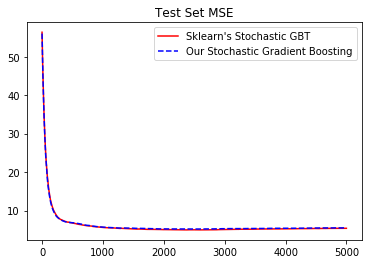

In [21]:
#List of the MSE's for each iteration
mse_list_adap = pd.DataFrame(mse_list_adap)

from sklearn.ensemble import GradientBoostingRegressor
n_est = 5000
#Building Sklearn's model also using 90% sampling
rnd_reg = GradientBoostingRegressor(max_depth=2, n_estimators=n_est, subsample = .9, learning_rate=.01) 
rnd_reg.fit(X_train,y_train)
predictions = rnd_reg.predict(X_test)
test_score = np.zeros((n_est,), dtype=np.float64)

for i, y_pred in enumerate(rnd_reg.staged_predict(X_test)):
    test_score[i] = (np.mean((y_test - y_pred)**2))

    

plt.plot(test_score, label = "Sklearn's Stochastic GBT", color = 'red')
plt.plot(mse_list_adap, label = 'Our Stochastic Gradient Boosting', color = 'blue', linestyle = 'dashed')
plt.legend()
plt.title('Test Set MSE')
plt.show()

The graph above illustates the comparison of the two algorithms.  This time there appears to be some slight differences, but this is to be expected due to the random nature of the sampling.  The error rates between the two implementations still converge and if we ran this model several times the average error of each implementation should be about the same.

## An illustration of Our Predictions Converging to the Actuals
Once again we illustrated the Test Actuals vs. Predictions for our implementation with an animation that can be seen below.  Please view as a ipynb.

In [24]:
from matplotlib import animation, rc

data = pd.DataFrame.transpose(test_predictions_list[test_predictions_list.columns[::50]])
def animate(nframe):
  plt.cla()
  plt.scatter(data.iloc[nframe], np.zeros_like(data.iloc[nframe]),label = 'Predicted', alpha = .8, s = 22**2)
  plt.title('Test Actuals vs. Predictions')
  plt.scatter(y_test, np.zeros_like(y_test),label = 'Actuals', alpha = .2, s= 22**2)
  plt.ylim(-.5,1.5)
  plt.xlim(0,60)
  plt.yticks([])
  plt.legend()
  plt.plot([y_test,data.iloc[nframe]], np.ones_like([y_test,data.iloc[nframe]]),marker = "o",markersize = 10,alpha = .2);
  

anim = animation.FuncAnimation(plt.figure(figsize=(8,6)), animate, frames=100);
rc('animation', html='html5')

In [25]:
anim

So far we have taken a look at the basic Gradient Boosting algorithm and the variation using stochasticity.  The next notebook will be focused on another variation which takes a different approach to the shrinkage parameter.  Instead of tuning the shrinkage using a static number we will be fitting a linear model to find the 'optimal' shrinkage.  We could do this with a standard regression but we will give it a Bayesian treatment which is extremely computationally expensive but the results can give us some very interesting insights.

Citations
1. Friedman, J. H. "Stochastic Gradient Boosting." (March 1999)
2. Breiman, Leo (1996). "Bagging predictors". Machine Learning. 24 (2): 123–140.